In [43]:
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [44]:
# 스타벅스 주식 예측

In [45]:
df = pd.read_csv("sbux.csv")

In [46]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [47]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1,1)
series

array([[28.185],
       [28.07 ],
       [28.13 ],
       ...,
       [54.69 ],
       [55.61 ],
       [54.46 ]])

In [48]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(series[:len(series)])
series = scaler.transform(series).flatten()
series

array([-1.94144714, -1.95251788, -1.94674184, ...,  0.61011874,
        0.6986847 ,  0.58797726])

In [49]:
# build a dataset
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T) :
    x = series[t: t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

In [50]:
X = np.array(X).reshape(-1 , T , 1) # N, T, D  형태로 변환하기
Y = np.array(Y)
N = len(X)
print(f"X.shape:{X.shape}, Y.shape:{Y.shape}, N.length:{N}")

X.shape:(1249, 10, 1), Y.shape:(1249,), N.length:1249


In [51]:
### try autoagressive RNN model

# build the model`
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss = 'mse',
    optimizer=Adam(lr=0.1),
    metrics=['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [52]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 5)                 140       
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [53]:
# train the RNN
r = model.fit(X[:-N//2], Y[:-N//2], epochs = 100, validation_data = (X[-N//2:], Y[-N//2:]))

Epoch 1/100
20/20 [==============================] - 2s 39ms/step - loss: 0.0825 - accuracy: 0.0000e+00 - val_loss: 0.0451 - val_accuracy: 0.0000e+00
Epoch 2/100
20/20 [==============================] - 0s 12ms/step - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 0.0223 - val_accuracy: 0.0000e+00
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0217 - val_accuracy: 0.0000e+00
Epoch 4/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 0.0145 - val_accuracy: 0.0000e+00
Epoch 5/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - val_loss: 0.0126 - val_accuracy: 0.0000e+00
Epoch 6/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 7/100
20/20 [==============================] - 0s 12ms/step - loss: 0.0026 - accuracy: 0.0000e

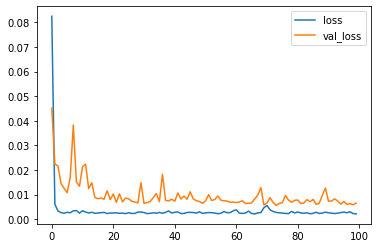

In [72]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [73]:
# One-step forecast using true targets 
predicts = model.predict(X)
predicts.shape
final_predictions = predicts[:, 0]
print(predicts.shape)

(1249, 1)


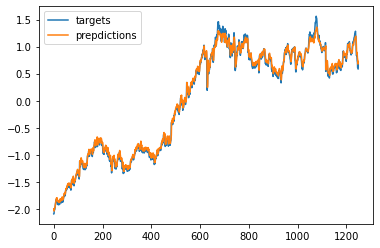

In [74]:
plt.plot(Y, label = 'targets')
plt.plot(final_predictions, label = 'prepdictions')
plt.legend()
plt.show()

In [78]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# lst train input
last_x = X[-N//2]
while len(validation_predictions) < len(validation_target) :
    p = model.predict(last_x.reshape(1, T, 1))[0, 0]
    validation_predictions.append(p)
    
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [80]:
last_x.shape

(10, 1)

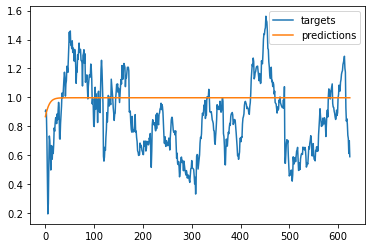

In [83]:
plt.plot(validation_target, label='targets')
plt.plot(validation_predictions, label='predictions')
plt.legend()
plt.show()

# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1)
df['PrevClose']

df.head()

In [104]:
# then the return is

df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [105]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


<AxesSubplot:>

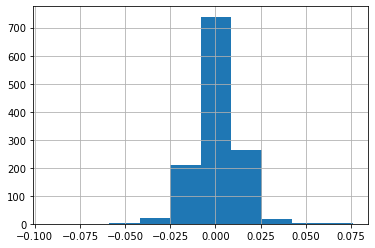

In [106]:
# Now let's try an LSTM to predict returns

df['Return'].hist()

In [107]:
series = df['Return'].values[1:].reshape(-1, 1)
# Normalize the data
# Note : I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series)
series = scaler.transform(series).flatten()

In [108]:
### build the dataset
# let's see if we can use T past values to predict the next value
### try autoagressive RNN model

# build the model`
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss = 'mse',
    optimizer=Adam(lr=0.1),
    metrics=['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [109]:
# build a dataset
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T) :
    x = series[t: t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

In [110]:
X = np.array(X).reshape(-1 , T , 1) # N, T, D  형태로 변환하기
Y = np.array(Y)
N = len(X)
print(f"X.shape:{X.shape}, Y.shape:{Y.shape}, N.length:{N}")

X.shape:(1248, 10, 1), Y.shape:(1248,), N.length:1248


In [111]:
# train the RNN
r = model.fit(X[:-N//2], Y[:-N//2], epochs = 100, validation_data = (X[-N//2:], Y[-N//2:]))

Epoch 1/100
20/20 [==============================] - 2s 24ms/step - loss: 0.9510 - accuracy: 0.0000e+00 - val_loss: 1.0708 - val_accuracy: 0.0000e+00
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 0.9424 - accuracy: 0.0000e+00 - val_loss: 1.0682 - val_accuracy: 0.0000e+00
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 0.9297 - accuracy: 0.0000e+00 - val_loss: 1.1149 - val_accuracy: 0.0000e+00
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 0.9313 - accuracy: 0.0000e+00 - val_loss: 1.0939 - val_accuracy: 0.0000e+00
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 0.9379 - accuracy: 0.0000e+00 - val_loss: 1.0767 - val_accuracy: 0.0000e+00
Epoch 6/100
20/20 [==============================] - 0s 11ms/step - loss: 0.9354 - accuracy: 0.0000e+00 - val_loss: 1.0768 - val_accuracy: 0.0000e+00
Epoch 7/100
20/20 [==============================] - 0s 11ms/step - loss: 0.9357 - accuracy: 0.0000e+0

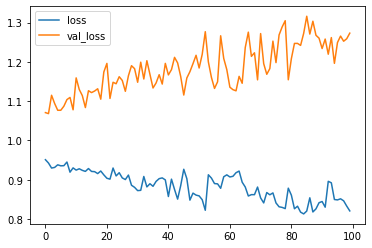

In [112]:
plt.plot(r.history['loss'], label ='loss')
plt.plot(r.history['val_loss'], label ='val_loss')
plt.legend()
plt.show()

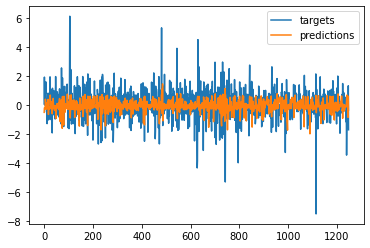

In [113]:
# One-step forecast using true targets
predicts = model.predict(X)
predicts.shape
final_predictions = predicts[:, 0]

plt.plot(Y, label='targets')
plt.plot(final_predictions, label='predictions')
plt.legend()
plt.show()

In [114]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# lst train input
last_x = X[-N//2]
while len(validation_predictions) < len(validation_target) :
    p = model.predict(last_x.reshape(1, T, 1))[0, 0]
    validation_predictions.append(p)
    
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

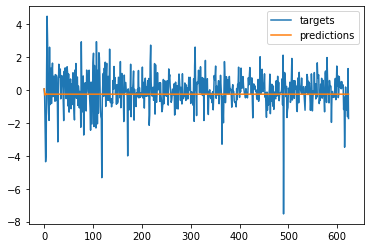

In [115]:
plt.plot(validation_target, label='targets')
plt.plot(validation_predictions, label='predictions')
plt.legend()
plt.show()

In [117]:
# Full data
# Not yet in the final "X " format
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [123]:
# Now make the actual data which will go into the neural net
T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [124]:
print(T, D, N)
print(input_data.shape)

10 5 1249
(1259, 5)


In [129]:
# normalize the data
Ntrain = len(input_data) * 2 // 3
print(Ntrain)
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)
input_data.shape

839


(1259, 5)

In [137]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

# 빈 array 규격 생성
for t in range(Ntrain) :
    X_train[t, : , :] = input_data[t: t + T]
    Y_train[t] = (targets[t+T] > 0)

# 이진 분류로 변환

In [142]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain) :
    # u counts from 0..(N-Ntrain)
    # t counts from Ntrain...N
    t = u + Ntrain
    X_test[u, : , :] = input_data[t: t+T]
    Y_test[u] = (targets[t+T] > 0)

In [145]:
# make the RNN
i = Input(shape = (T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(lr=0.001)
    metrics = ['accuracy']
)

SyntaxError: invalid syntax (Temp/ipykernel_21448/3764199403.py, line 9)

In [146]:
r = model.fit(
    X_train, Y_train,
    batch_size = 32,
    epochs = 300,
    validation_data = (X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 3s 40ms/step - loss: 0.6961 - val_loss: 0.6982
Epoch 2/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6934 - val_loss: 0.6966
Epoch 3/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6913 - val_loss: 0.6948
Epoch 4/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6905 - val_loss: 0.6942
Epoch 5/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6910 - val_loss: 0.6924
Epoch 6/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6910 - val_loss: 0.6994
Epoch 7/300
27/27 [==============================] - 0s 8ms/step - loss: 0.6895 - val_loss: 0.6952
Epoch 8/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6901 - val_loss: 0.6978
Epoch 9/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6885 - val_loss: 0.6914
Epoch 10/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6887 - val_loss: 0.6926
Epoc

In [151]:
# plot the accuracy
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

KeyError: 'accuracy'

### 주가 예측
- TALib (Linux  설치 필요) -> 클라우드 Docker
- 매주 금요일에 시작가 , 오를것인지, 내릴것인지 2가지를 분류
- LSTM (시계열 데이터)

In [ ]:
# stooq.com